In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5,),
        (0.5,)
        # (0.485, 0.456, 0.406), 
        # (0.229, 0.224, 0.225)
        ),   
])

train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
    )
train_loader = DataLoader(
    train_dataset, 
    batch_size=64,
    shuffle=True
    )


In [15]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(100, 256),  # 입력 차원이 100이고 출력 차원이 256인 선형 레이어를 정의
            nn.LeakyReLU(0.2), # ??? LeakyReLU는 입력이 음수일 때 일정한 기울기를 가지는 ReLU
            nn.Linear(256, 512), # 이전 레이어의 출력 차원이 256이고 출력 차원이 512인 선형 레이어를 정의
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh() # ?? Tanh 함수는 입력 값을 -1과 1 사이의 값으로 정규화
        )

    def forward(self, x): # ?? 모델의 입력에서 출력을 계산하는 데 사용
        return self.model(x).view(-1, 1, 28, 28)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024), # 이미지 크기 24x24 
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3), # Dropout은 신경망의 과적합을 방지하기 위해 무작위로 일부 뉴런을 비활성화하는 기법입니다. 여기서는 30%의 확률로 뉴런을 비활성화
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid() # ?? Sigmoid 함수는 출력을 0과 1 사이로 압축하여 이진 분류를 위한 확률 값을 생성
        )
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.model(x)

In [16]:
generator = Generator()
discriminator = Discriminator()

criterion = nn.BCELoss() # 손실 함수인 이진 교차 엔트로피 손실(Binary Cross Entropy Loss)을 정의
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002) #  Adam 옵티마이저를 생성합니다. Adam은 경사 하강법 알고리즘 중 하나로, 모델을 학습
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002) # ? 왜 0.0002

In [18]:
epochs = 100
for epoch in range(epochs): # 에포크(epoch) 동안 반복할 것인지를 지정합니다. 각 에포크마다 모델의 성능을 평가하고 업데이트
    for i, (images, _) in enumerate(train_loader):
        # - 진짜와 가짜 레이블 생성
        real_labels = torch.ones(images.size(0), 1) # ?images.size(0)은 뭐고 1 은 뭘까
        fake_labels = torch.zeros(images.size(0), 1)

        # - 진짜 이미지를 사용하여 판별자를 학습합니다.
        outputs = discriminator(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # - 가짜 이미지 생성 및 판별자 학습
        noise = torch.randn(images.size(0), 100) # ? 100  100 벡터??
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # - 판별자의 손실 및 업데이트
        d_loss = d_loss_real + d_loss_fake
        optimizer_d.zero_grad() # ? 구분자의 그래디언트를 초기화 
        d_loss.backward() # ? 손실에 대한 역전파를 수행
        optimizer_d.step() # 옵티마이저를 사용하여 구분자의 파라미터를 업데이트합니다. 역전파로 계산된 그래디언트를 바탕으로 구분자의 파라미터를 조정하여 손실을 최소화

        # - 생성자의 손실 및 업데이트
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}, D(x): {real_score.mean().item()}, D(G(z)): {fake_score.mean().item()}')


Epoch [1/100], Step [100/938], d_loss: 1.1341967582702637, g_loss: 2.3000922203063965, D(x): 0.6866971850395203, D(G(z)): 0.44473057985305786
Epoch [1/100], Step [200/938], d_loss: 0.258823424577713, g_loss: 2.7281856536865234, D(x): 0.9156402349472046, D(G(z)): 0.13485851883888245
Epoch [1/100], Step [300/938], d_loss: 0.41817906498908997, g_loss: 2.9258410930633545, D(x): 0.8319849371910095, D(G(z)): 0.12014203518629074
Epoch [1/100], Step [400/938], d_loss: 3.8464195728302, g_loss: 1.535269021987915, D(x): 0.6621833443641663, D(G(z)): 0.817468523979187
Epoch [1/100], Step [500/938], d_loss: 0.03441425412893295, g_loss: 4.5680012702941895, D(x): 0.9792630672454834, D(G(z)): 0.011535584926605225
Epoch [1/100], Step [600/938], d_loss: 4.645054817199707, g_loss: 3.673854351043701, D(x): 0.8960239887237549, D(G(z)): 0.9180202484130859
Epoch [1/100], Step [700/938], d_loss: 0.12085080146789551, g_loss: 4.254382133483887, D(x): 0.9616947174072266, D(G(z)): 0.07206088304519653
Epoch [1/100]

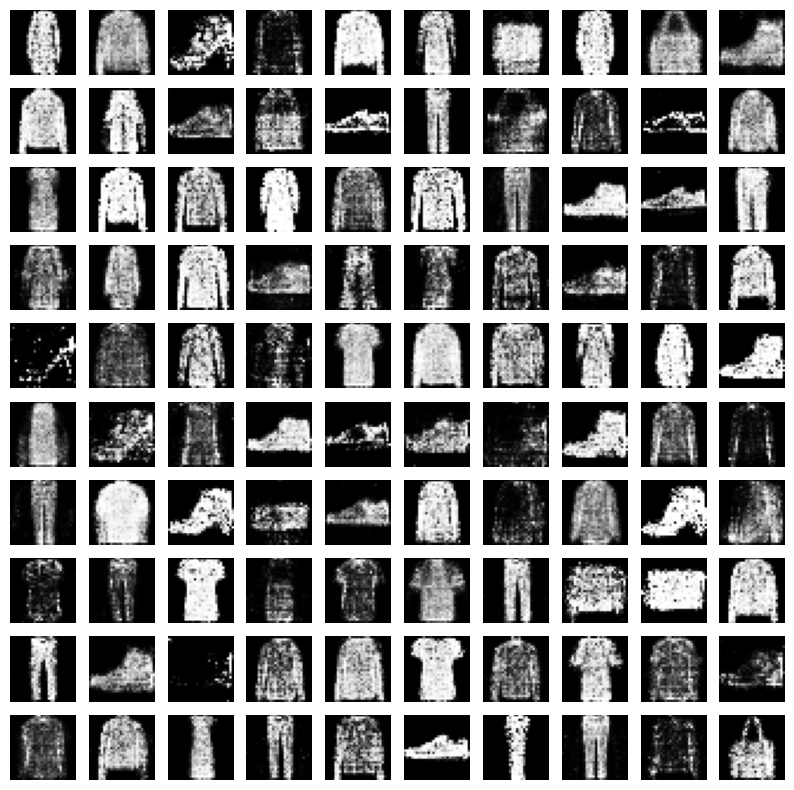

In [19]:

noise = torch.randn(100, 100) 
fake_images = generator(noise)
fake_images = fake_images.reshape(fake_images.size(0), 28, 28) 
fake_images = fake_images.detach().numpy() 

plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(fake_images[i], cmap='gray')
    plt.axis('off')
plt.show()
